<a href="https://colab.research.google.com/github/MFaishalRamadhan/Capstone/blob/main/Collaborative_Based_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# data
import pandas as pd
import numpy as np
from zipfile import ZipFile
from pathlib import Path
import math
import random

# visualisation data
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_palette('Set1')
sns.set()

# modeling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import RootMeanSquaredError
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
import joblib
from tensorflow.keras import regularizers

# remove warnings for plotting seaborn
import warnings
warnings.filterwarnings('ignore')

# for upload file
import os

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
users_dataset = pd.read_excel(r'/content/gdrive/My Drive/Colab Notebooks/Dataset/Users_Dataset.xlsx')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
users_dataset

User_ID  Place_ID  Rating_x                              Name  \
0             4       406         4                  Mr.K Cafe Gombel   
1             6       406         3                  Mr.K Cafe Gombel   
2            10       406         2                  Mr.K Cafe Gombel   
3            12       406         3                  Mr.K Cafe Gombel   
4            12       406         3                  Mr.K Cafe Gombel   
...         ...       ...       ...                               ...   
822816    16999       405         5  Jual Souvenir Semarang - Progift   
822817    17093       405         1  Jual Souvenir Semarang - Progift   
822818    17242       405         1  Jual Souvenir Semarang - Progift   
822819    17407       405         2  Jual Souvenir Semarang - Progift   
822820    17501       405         2  Jual Souvenir Semarang - Progift   

                                                    Image  \
0       https://lh5.googleusercontent.com/p/AF1QipOh43...   
1       https://lh5.googleusercontent.com/p/AF1QipOh43...   
2       https://lh5.googleusercontent.com/p/AF1QipOh43...   
3       https://lh5.googleusercontent.com/p/AF1QipOh43...   
4       https://lh5.googleusercontent.com/p/AF1QipOh43...   
...                                                   ...   
822816  https://lh5.googleusercontent.com/p/AF1QipOday...   
822817  https://lh5.googleusercontent.com/p/AF1QipOday...   
822818  https://lh5.googleusercontent.com/p/AF1QipOday...   
822819  https://lh5.googleusercontent.com/p/AF1QipOday...   
822820  https://lh5.googleusercontent.com/p/AF1QipOday...   

                                                      URL  Rating_y  \
0       https://www.google.co.id/maps/place/Mr.K+Cafe+...       4.5   
1       https://www.google.co.id/maps/place/Mr.K+Cafe+...       4.5   
2       https://www.google.co.id/maps/place/Mr.K+Cafe+...       4.5   
3       https://www.google.co.id/maps/place/Mr.K+Cafe+...       4.5   
4       https://www.google.co.id/maps/place/Mr.K+Cafe+...       4.5   
...                                                   ...       ...   
822816  https://www.google.com/maps/place/Jual+Souveni...       5.0   
822817  https://www.google.com/maps/place/Jual+Souveni...       5.0   
822818  https://www.google.com/maps/place/Jual+Souveni...       5.0   
822819  https://www.google.com/maps/place/Jual+Souveni...       5.0   
822820  https://www.google.com/maps/place/Jual+Souveni...       5.0   

        Num_Rating      Category  \
0             6257          Kafe   
1             6257          Kafe   
2             6257          Kafe   
3             6257          Kafe   
4             6257          Kafe   
...            ...           ...   
822816          95  Toko Suvenir   
822817          95  Toko Suvenir   
822818          95  Toko Suvenir   
822819          95  Toko Suvenir   
822820          95  Toko Suvenir   

                                                  Address   Longitude  \
0         Jl. Setia Budi No.28, Banyumanik, Kota Semarang  110.418685   
1         Jl. Setia Budi No.28, Banyumanik, Kota Semarang  110.418685   
2         Jl. Setia Budi No.28, Banyumanik, Kota Semarang  110.418685   
3         Jl. Setia Budi No.28, Banyumanik, Kota Semarang  110.418685   
4         Jl. Setia Budi No.28, Banyumanik, Kota Semarang  110.418685   
...                                                   ...         ...   
822816  Jalan Selo Mas Timur IX no 437, Tugu, Kota Sem...  110.401493   
822817  Jalan Selo Mas Timur IX no 437, Tugu, Kota Sem...  110.401493   
822818  Jalan Selo Mas Timur IX no 437, Tugu, Kota Sem...  110.401493   
822819  Jalan Selo Mas Timur IX no 437, Tugu, Kota Sem...  110.401493   
822820  Jalan Selo Mas Timur IX no 437, Tugu, Kota Sem...  110.401493   

        Latitude  
0      -7.038795  
1      -7.038795  
2      -7.038795  
3      -7.038795  
4      -7.038795  
...          ...  
822816 -6.959994  
822817 -6.959994  
822818 -6.959994  
822819 -6.959994  
822820 -6.959994  

[82282

In [ ]:
# Encode categorical variables
user_encoder = LabelEncoder()
place_encoder = LabelEncoder()

In [ ]:
users_dataset['user_encoded'] = user_encoder.fit_transform(users_dataset['User_ID'])
users_dataset['place_encoded'] = place_encoder.fit_transform(users_dataset['Place_ID'])

In [ ]:
train_df, test_df = train_test_split(users_dataset, test_size=0.2, random_state=42)

In [ ]:
# Define input layers
user_input = Input(shape=(1,))
place_input = Input(shape=(1,))

# Flatten the inputs
user_flatten = Flatten()(user_input)
place_flatten = Flatten()(place_input)

# Concatenate the inputs
concatenated = Concatenate()([user_flatten, place_flatten])

# Define hidden layers with regularization
hidden1 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(concatenated)
hidden2 = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(hidden1)

# Output layer
output = Dense(1)(hidden2)

In [ ]:
model = Model(inputs=[user_input, place_input], outputs=output)

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [ ]:
X_train = [train_df['user_encoded'], train_df['place_encoded']]
y_train = train_df['Rating_x']
# Prepare the test data
X_test = [test_df['user_encoded'], test_df['place_encoded']]
y_test = test_df['Rating_x']

# Train the model with validation data
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=512)

Epoch 1/30
1286/1286 [==============================] - 7s 3ms/step - loss: 994.1785 - accuracy: 0.1801 - val_loss: 3.5860 - val_accuracy: 0.1967
Epoch 2/30
1286/1286 [==============================] - 4s 3ms/step - loss: 4.2383 - accuracy: 0.1973 - val_loss: 28.3733 - val_accuracy: 0.1974
Epoch 3/30
1286/1286 [==============================] - 5s 4ms/step - loss: 78.4225 - accuracy: 0.1602 - val_loss: 40.4093 - val_accuracy: 0.0277
Epoch 4/30
1286/1286 [==============================] - 4s 3ms/step - loss: 77.2212 - accuracy: 0.1556 - val_loss: 80.2650 - val_accuracy: 0.0236
Epoch 5/30
1286/1286 [==============================] - 4s 3ms/step - loss: 65.5202 - accuracy: 0.1646 - val_loss: 11.8387 - val_accuracy: 0.1974
Epoch 6/30
1286/1286 [==============================] - 4s 3ms/step - loss: 63.7284 - accuracy: 0.1735 - val_loss: 5.6904 - val_accuracy: 0.1974
Epoch 7/30
1286/1286 [==============================] - 5s 4ms/step - loss: 59.2550 - accuracy: 0.1665 - val_loss: 47.4187 - v

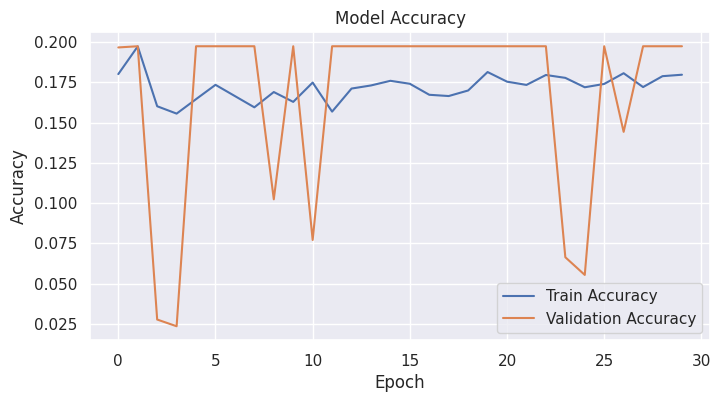

In [ ]:
# take accuracy and validation from history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# accuracy plot
plt.figure(figsize=(8, 4))
plt.plot(accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

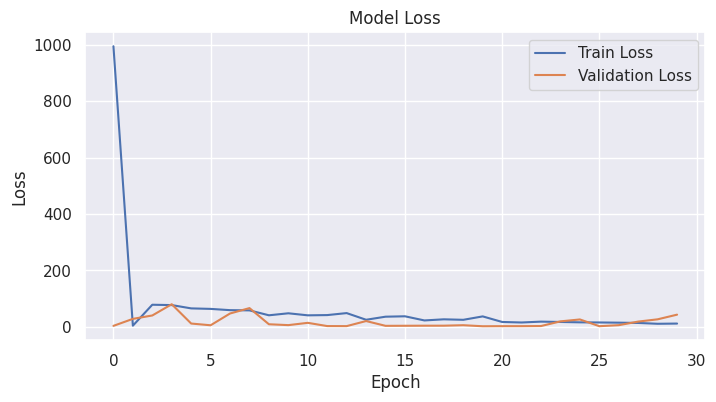

In [ ]:
# loss plot
plt.figure(figsize=(8, 4))
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def calculate_distance(location1, location2):
    lat1, lon1 = location1
    lat2, lon2 = location2
    # Calculate the distance using the Haversine formula
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = math.sin(dlat / 2) ** 2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = 6371 * c  # Earth's radius is approximately 6371 km

    return distance

In [ ]:
def get_recommendations():
    # Get the JSON data from the request
    user_latitude = -6.898647901908838
    user_longitude = 110.40228767871858
    user_location = (user_latitude, user_longitude)

    # Get all unique places
    unique_places = users_dataset['Place_ID'].unique()

    # Encode the categorical variables
    user_encoder = LabelEncoder()
    place_encoder = LabelEncoder()
    users_dataset['user_encoded'] = user_encoder.fit_transform(users_dataset['User_ID'])
    users_dataset['place_encoded'] = place_encoder.fit_transform(users_dataset['Place_ID'])

    # Generate a random user ID
    user_id = random.choice(users_dataset['User_ID'].unique())

    # Get recommendations for the specific user
    user_id_encoded = user_encoder.transform([user_id])[0]
    user_input = np.full(len(unique_places), user_id_encoded)
    place_input = np.arange(len(unique_places))

    # Predict ratings for the user and sort them in descending order
    predictions = model.predict([user_input, place_input]).flatten()
    sorted_indices = np.argsort(predictions)[::-1]

    # Get the top 5 recommendations
    top_5_collaborative_places = unique_places[sorted_indices[:5]]

    # Get the recommended places' details
    collaborative_recommendations = users_dataset[users_dataset['Place_ID'].isin(top_5_collaborative_places)][
        ['Place_ID', 'Name', 'Rating_y', 'Num_Rating', 'Latitude', 'Longitude',
         'Category', 'Address', 'Image', 'URL']]. \
        sort_values('Rating_y', ascending=False)

    # Calculate and add the distance for each recommended place
    collaborative_recommendations['distance'] = collaborative_recommendations.apply(
        lambda row: calculate_distance(user_location, (row['Latitude'], row['Longitude'])), axis=1)
    collaborative_recommendations['distance'] = collaborative_recommendations['distance'].apply(lambda d: f"{round(d, 2)} km")

    # Filter out any duplicate places
    collaborative_recommendations = collaborative_recommendations.drop_duplicates(subset=['Name'])

    # Create a list of recommended place dictionaries
    collaborative_recommended = []
    for _, row in collaborative_recommendations.iterrows():
        distance_str = row['distance'].split(' ')[0]
        distance = float(distance_str)
        place = {
            'place_id': row['Place_ID'],  # Add the place ID to the result
            'name': row['Name'],
            'rating': row['Rating_y'],
            'num_ratings': row['Num_Rating'],
            'category': row['Category'],
            'address': row['Address'],
            'image': row['Image'],
            'url': row['URL'],
            'distance': f"{round(distance, 2)} km"
        }
        collaborative_recommended.append(place)
    # Return the list of recommended places
    return collaborative_recommended

In [ ]:
recommended_places = get_recommendations()

for place in recommended_places:
    print("Place ID:", place['place_id'])
    print("Name:", place['name'])
    print("Rating:", place['rating'])
    print("Num_Rating:", place['num_ratings'])
    print("Category:", place['category'])
    print("Address:", place['address'])
    print("Distance:", place['distance'])
    print("Image:", place['image'])
    print("URL:", place['url'])
    print()

18/18 [==============================] - 0s 1ms/step
Place ID: 405
Name: Jual Souvenir Semarang - Progift
Rating: 5.0
Num_Rating: 95
Category: Toko Suvenir
Address: Jalan Selo Mas Timur IX no 437, Tugu, Kota Semarang
Distance: 6.82 km
Image: https://lh5.googleusercontent.com/p/AF1QipOdayen4nD7cfTzT4t1OlHQQCcWCl1p2BrLVYme=w92-h92-k-no
URL: https://www.google.com/maps/place/Jual+Souvenir+Semarang+-+Progift/data=!4m7!3m6!1s0x2e708b6cf74cf005:0x4758f799490d8cd0!8m2!3d-6.9599944!4d110.4040678!16s%2Fg%2F11gzrwb7ys!19sChIJBfBM92yLcC4R0IwNSZn3WEc?authuser=0&hl=id&rclk=1

Place ID: 402
Name: Toko Souvenir : Kraskress_craft
Rating: 5.0
Num_Rating: 1
Category: Toko Suvenir
Address: 283F+QWW, Jl. Bukit Beringin Tim. IV, Tugu, Kota Semarang
Distance: 13.93 km
Image: https://streetviewpixels-pa.googleapis.com/v1/thumbnail?panoid=W2oMupw_Wk7yMmPCfbwiVA&cb_client=search.gws-prod.gps&w=80&h=92&yaw=313.138&pitch=0&thumbfov=100
URL: https://www.google.com/maps/place/Toko+Souvenir+:+Kraskress_craft/data=!

In [ ]:
model.save('collaborative_model.h5')

In [ ]:
# Save the model using joblib
joblib.dump(model, 'collaborative_model.pkl')

['collaborative_model.pkl']

In [ ]:
# Save the model using joblib
joblib.dump(model, 'collaborative_model.joblib')

['collaborative_model.joblib']

In [ ]:
import tensorflow as tf

# Load the H5 model
model = tf.keras.models.load_model('collaborative_model.h5')

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('collaborative_model.tflite', 'wb') as f:
    f.write(tflite_model)